In [1]:
import torch
from torch import nn

import math
import matplotlib.pyplot as plt


In [2]:
RANDOM_SEED = 111
torch.manual_seed(RANDOM_SEED)

In [3]:
# Check for CUDA availability
if torch.cuda.is_available():
    print("CUDA Available")
    device = torch.device("cuda")  # Use the GPU
else:
    print("CUDA Not Available")
    device = torch.device("cpu")   # Use the CPU


CUDA Available


Preparing training data

In [57]:
train_data_length = 1024
# We will use a sin graph as our real data
train_data = torch.zeros((train_data_length, 2)).to(device=device)
# train_data[:, 0] means all rows, 0th column (In here our first column will be x data)
# Random value from 0 to 2pi for x data
train_data[:, 0] = 2 * math.pi * torch.rand(train_data_length).to(device=device) # x data
# train_data[:, 1] means all rows, 1st column (In here our second column will be y data)
# torch.sin is the answer to our model
# y is the actual label
train_data[:, 1] = torch.sin(train_data[:, 0]).to(device=device) # y data

# the labels are required by pytorch data loader. But since GAN make use of unsuperivsed learning, we don't need labels
train_labels = torch.zeros(train_data_length)
train_set = [
    (train_data[i], train_labels[i]) for i in range(train_data_length)
]


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

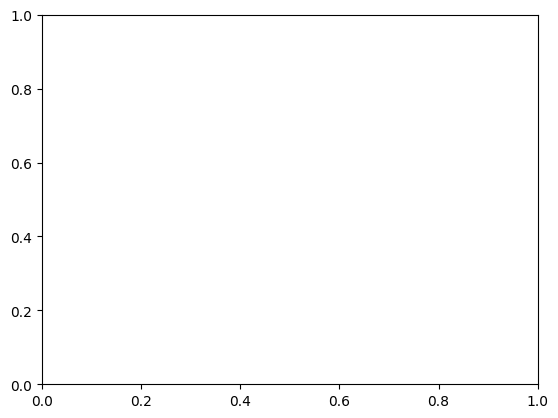

In [58]:
plt.plot(train_data[:, 0].cpu(), train_data[:, 1].cpu(), ".") # we need to use cpu() because we are using cuda

In [59]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

Implement Discriminator: Discriminator outputs a one-dimensional probability (1 means real, 0 means fake)

In [60]:
class Discriminator(nn.Module):
    def __init__(self):
        # We use an MLP with 3 hidden layers
        # You can change this to any architecture you want
        # You may use Conv2d as well
        super().__init__()
        self.model = nn.Sequential(
            # 2 input features, 256 output features (hidden layer)
            nn.Linear(2, 256),
            nn.ReLU(),
            # Dropout layer to prevent overfitting
            # the number is the probability of dropping out a neuron
            nn.Dropout(0.3),
            # 256 input features, 128 output features (hidden layer)
            # Since we had 256 hidden features in the previous layer, we need to have 256 input features in this layer
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            # 128 input features, 64 output features (hidden layer)
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            # 64 input features, 1 output features (output layer)
            nn.Linear(64, 1),
            # Since this is a binary classification, we use sigmoid at the end (if it was a multi-class classification, we would use softmax)
            nn.Sigmoid()
        )
    
    # x is the input data
    # in this model the x should have 2 features (x and y)
    # We first train the Discriminator on the real data
    def forward(self, x):
        output = self.model(x)
        return output

In [61]:
discriminator = Discriminator().to(device=device)

Implementing Generator: Generator outputs a fake data that is intended to fool the discriminator

In [62]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 2)
        )
    
    def forward(self, x):
        output = self.model(x)
        return output




In [63]:
generator = Generator().to(device=device)

Train the model.

In [64]:
lr = 0.001 # learning rate
num_epochs = 300 # number of epochs
loss_function = nn.BCELoss() # Binary Cross Entropy Loss (since we are doing binary classification - whether the data is real or fake)


In [65]:
# We will use Adam optimizer
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [66]:
for epoch in range(num_epochs):
    for n, (real_samples, _) in enumerate(train_loader):
        real_samples_labels = torch.ones((batch_size, 1)).to(device=device)

        latent_space_samples = torch.randn((batch_size, 2)).to(device=device)
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1)).to(device=device)
        all_samples = torch.cat((real_samples, generated_samples)).to(device=device)
        all_samples_labels = torch.cat((real_samples_labels, generated_samples_labels)).to(device=device)

        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        latent_space_samples = torch.randn((batch_size, 2)).to(device=device)
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(output_discriminator_generated, real_samples_labels)
        discriminator.zero_grad()
        generator.zero_grad()
        loss_generator.backward()
        optimizer_generator.step()

        if epoch % 10 == 0 and n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")


Epoch: 0 Loss D.: 0.08866985887289047
Epoch: 0 Loss G.: 2.7698917388916016
Epoch: 10 Loss D.: 0.5289490818977356
Epoch: 10 Loss G.: 1.1443384885787964
Epoch: 20 Loss D.: 0.5869083404541016
Epoch: 20 Loss G.: 0.9931597709655762
Epoch: 30 Loss D.: 0.6270803213119507
Epoch: 30 Loss G.: 0.9926261901855469
Epoch: 40 Loss D.: 0.625130295753479
Epoch: 40 Loss G.: 0.7606579661369324
Epoch: 50 Loss D.: 0.6987178325653076
Epoch: 50 Loss G.: 0.8083146810531616
Epoch: 60 Loss D.: 0.6910607218742371
Epoch: 60 Loss G.: 0.7647202610969543
Epoch: 70 Loss D.: 0.6991082429885864
Epoch: 70 Loss G.: 0.6622576117515564
Epoch: 80 Loss D.: 0.6705498695373535
Epoch: 80 Loss G.: 0.7437602281570435
Epoch: 90 Loss D.: 0.6476490497589111
Epoch: 90 Loss G.: 0.9166446924209595
Epoch: 100 Loss D.: 0.7176741361618042
Epoch: 100 Loss G.: 0.7915918827056885
Epoch: 110 Loss D.: 0.68668532371521
Epoch: 110 Loss G.: 0.7080502510070801
Epoch: 120 Loss D.: 0.6887176036834717
Epoch: 120 Loss G.: 0.6818917989730835
Epoch: 130

Checking the samples generated by GAN

In [67]:
latent_space_samples = torch.randn(100, 2).to(device=device)
# Now our trained generator will generate 100 samples that are able to fool the discriminator
generated_samples = generator(latent_space_samples)

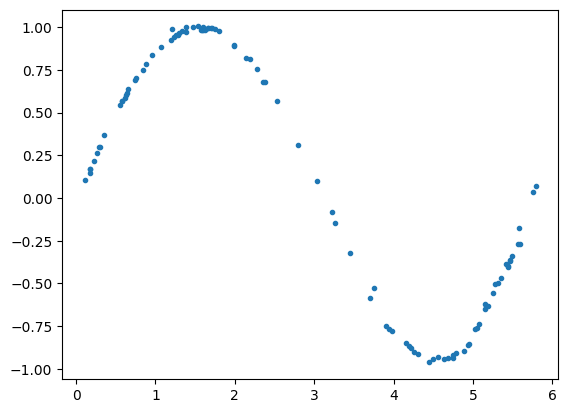

In [68]:
generated_samples = generated_samples.cpu().detach()
plt.plot(generated_samples[:, 0], generated_samples[:, 1], ".")